In [ ]:
# in this notebook, we load two cluster assignments, create dictionaries using the shared examples only based on their keys, and measure their similarities.

In [1]:
# let's load a few important packages for checking the cluster similarities
import numpy as np
import pandas as pd
import os
import sys
import json
from collections import Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt

In [2]:
# let's load the target/ground-truth cluster assignments. it's in `root_id_type_dict.pkl` file.
import pickle
root_id_type_dict = pickle.load(open('root_id_type_dict.pkl', 'rb'))

In [4]:
# let's load the estimated cluster assignments from `cluster_assignment_dict.npy`
pca_cluster_assignment_dict = np.load('pca_cluster_assignment_dict_tuned.npy', allow_pickle=True).item()
lv_cluster_assignment_dict = np.load('cluster_assignment_dict.npy', allow_pickle=True).item()

In [3]:
# first, let's create a dictionary of the keys of `root_id_type_dict` mapped to integer indices.
root_id_type_dict_keys = list(root_id_type_dict.keys())
root_id_type_dict_keys_dict = {root_id_type_dict_keys[i]: i for i in range(len(root_id_type_dict_keys))}

In [6]:
list(pca_cluster_assignment_dict.keys())[1]

720575940631267655

In [7]:
shared_root_ids = list(set(root_id_type_dict.keys())
                       .intersection(set(pca_cluster_assignment_dict.keys())
                                     .intersection(set(lv_cluster_assignment_dict.keys()))))

In [4]:
root_id_type_dict_cluster_strings = list(set(root_id_type_dict.values()))
cluster_string_to_cid = dict([(cluster_string, cid) 
                              for cid, cluster_string
                              in enumerate(root_id_type_dict_cluster_strings)])
cid_to_cluster_string = dict([(cid, cluster_string) 
                              for cluster_string, cid
                              in cluster_string_to_cid.items()])
print(f'there are {len(cluster_string_to_cid)} unique cluster assignments in the ground-truth data.')

there are 744 unique cluster assignments in the ground-truth data.


In [9]:
gt_assignments = np.array([cluster_string_to_cid[root_id_type_dict[root_id]] for root_id in shared_root_ids])
pca_assignments = np.array([pca_cluster_assignment_dict[root_id] for root_id in shared_root_ids])
lv_assignments = np.array([lv_cluster_assignment_dict[root_id] for root_id in shared_root_ids])

In [10]:
gt_assignments[:10], pca_assignments[:10], lv_assignments[:10]

(array([596,  49,  49, 465,  66, 502,  49, 558, 442, 572]),
 array([534, 544, 783,  77, 250, 895,  72, 615, 951,  92]),
 array([504, 904, 677, 765, 156,  58, 102, 219,  79, 102]))

In [11]:
# tuned pca k means
gt_assignments[:10], pca_assignments[:10], lv_assignments[:10]

(array([596,  49,  49, 465,  66, 502,  49, 558, 442, 572]),
 array([534, 544, 783,  77, 250, 895,  72, 615, 951,  92]),
 array([504, 904, 677, 765, 156,  58, 102, 219,  79, 102]))

In [12]:
print(f'# of unique cluster assignments in the ground-truth data: {len(np.unique(gt_assignments))}')
print(f'# of unique cluster assignments in the PCA data: {len(np.unique(pca_assignments))}')
print(f'# of unique cluster assignments in the LV data: {len(np.unique(lv_assignments))}')

# of unique cluster assignments in the ground-truth data: 744
# of unique cluster assignments in the PCA data: 1024
# of unique cluster assignments in the LV data: 685


In [17]:
# tune pca k means
print(f'# of unique cluster assignments in the ground-truth data: {len(np.unique(gt_assignments))}')
print(f'# of unique cluster assignments in the PCA data: {len(np.unique(pca_assignments))}')
print(f'# of unique cluster assignments in the LV data: {len(np.unique(lv_assignments))}')

# of unique cluster assignments in the ground-truth data: 744
# of unique cluster assignments in the PCA data: 1024
# of unique cluster assignments in the LV data: 685


In [11]:
# create a random assignment by randomly permuting `target_assignment`
random_assignment_optimistic = np.random.permutation(gt_assignments)
random_assignment_pessimistic = np.random.randint(0, np.unique(gt_assignments).shape[0], gt_assignments.shape[0])

In [14]:
print(f'# of unique cluster assignments in the random assignment (optimistic): {len(np.unique(random_assignment_optimistic))}')
print(f'# of unique cluster assignments in the random assignment (pessimistic): {len(np.unique(random_assignment_pessimistic))}')

# of unique cluster assignments in the random assignment (optimistic): 744
# of unique cluster assignments in the random assignment (pessimistic): 744


In [5]:
def confusion_matrix(X, Y):
    assert len(X) == len(Y)

    unique_x = np.unique(X)
    unique_y = np.unique(Y)

    x_dict = dict([(unique_x[i], i) for i in range(len(unique_x))])
    y_dict = dict([(unique_y[i], i) for i in range(len(unique_y))])

    confusion_matrix = np.zeros((len(unique_x), len(unique_y)))

    for i in range(len(X)):
        confusion_matrix[x_dict[X[i]], y_dict[Y[i]]] += 1

    return confusion_matrix

In [6]:
from scipy.optimize import linear_sum_assignment

def compare_two_assignments(assignment_A, assignment_B):
    confusion_matrix_value = confusion_matrix(assignment_A, assignment_B)

    # Align clusters using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(confusion_matrix_value, maximize=True)
    score = confusion_matrix_value[row_ind, col_ind].sum()

    # Reorder columns of the confusion matrix to align clusters
    aligned_confusion_matrix = confusion_matrix_value[:, col_ind]

    return score, aligned_confusion_matrix

In [17]:
# compare the ground-truth assignment against (a) PCA assignment, (b) LV assignment, (c) random assignment (optimistic), and (d) random assignment (pessimistic)
score_pca, _ = compare_two_assignments(gt_assignments, pca_assignments)
score_lv, _ = compare_two_assignments(gt_assignments, lv_assignments)
score_random_optimistic, _ = compare_two_assignments(gt_assignments, random_assignment_optimistic)
score_random_pessimistic, _ = compare_two_assignments(gt_assignments, random_assignment_pessimistic)

print(f'PCA: {score_pca}')
print(f'LV: {score_lv}')
print(f'Random (optimistic): {score_random_optimistic}')
print(f'Random (pessimistic): {score_random_pessimistic}')

PCA: 1228.0
LV: 20398.0
Random (optimistic): 2282.0
Random (pessimistic): 1275.0


In [18]:
# tuned pca k means
# compare the ground-truth assignment against (a) PCA assignment, (b) LV assignment, (c) random assignment (optimistic), and (d) random assignment (pessimistic)
score_pca, _ = compare_two_assignments(gt_assignments, pca_assignments)
score_lv, _ = compare_two_assignments(gt_assignments, lv_assignments)
score_random_optimistic, _ = compare_two_assignments(gt_assignments, random_assignment_optimistic)
score_random_pessimistic, _ = compare_two_assignments(gt_assignments, random_assignment_pessimistic)

print(f'PCA: {score_pca}')
print(f'LV: {score_lv}')
print(f'Random (optimistic): {score_random_optimistic}')
print(f'Random (pessimistic): {score_random_pessimistic}')

PCA: 1228.0
LV: 20398.0
Random (optimistic): 2282.0
Random (pessimistic): 1275.0


In [16]:
# check the similarity between PCA and LV assignments
score_pca_lv, _ = compare_two_assignments(pca_assignments, lv_assignments)

print(f"PCA vs. LV: {score_pca_lv}")

PCA vs. LV: 4502.0


In [23]:
# tuned pca k means
# check the similarity between PCA and LV assignments
score_pca_lv, _ = compare_two_assignments(pca_assignments, lv_assignments)

print(f"PCA vs. LV: {score_pca_lv}")

PCA vs. LV: 1458.0


In [8]:
from matplotlib import pyplot as plot

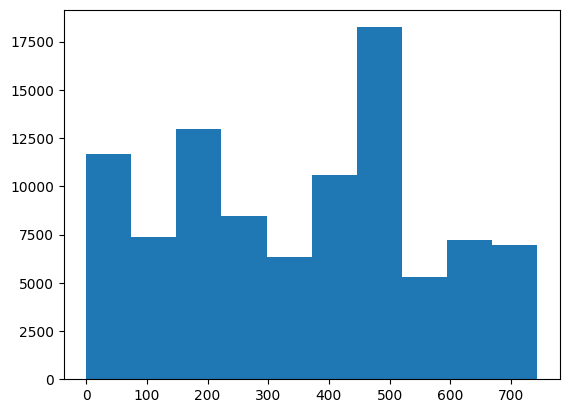

In [22]:
plot.figure()

plot.hist(gt_assignments)

plot.show()

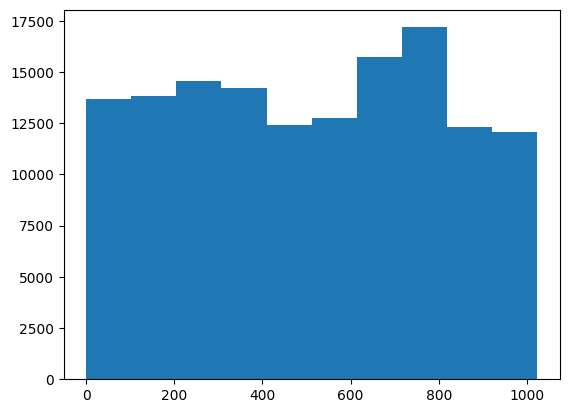

In [12]:
plot.figure()

plot.hist(lv_assignments)

plot.show()

Runs found : 48
Mean score : 1224.6875
95% CI     : [1209.0000, 1239.8250]


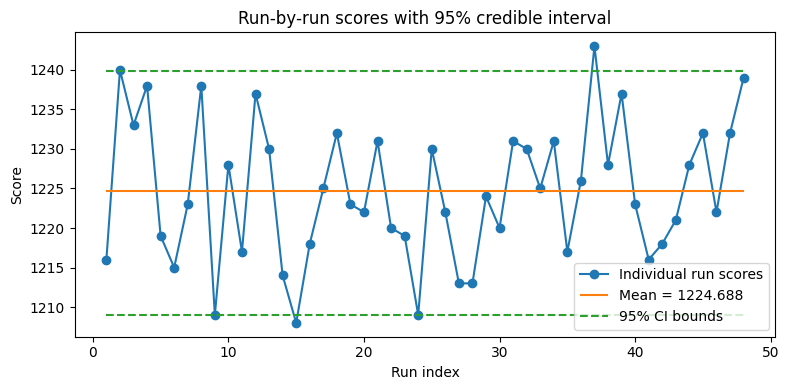

In [18]:
scores = []

for i in range(48):
    pca_cluster_assignment_dict = np.load(f"runs/pca_cluster_assignment_dict_tuned_{i+1}.npy", allow_pickle=True).item()
    shared_root_ids = list(set(root_id_type_dict.keys())
                       .intersection(set(pca_cluster_assignment_dict.keys())))
    gt_assignments = np.array([cluster_string_to_cid[root_id_type_dict[root_id]] for root_id in shared_root_ids])
    pca_assignments = np.array([pca_cluster_assignment_dict[root_id] for root_id in shared_root_ids])
    score_pca, _ = compare_two_assignments(gt_assignments, pca_assignments)
    scores.append(score_pca)
    
scores = np.array(scores)
mean_score = scores.mean()
lower, upper = np.percentile(scores, [2.5, 97.5])

print(f"Runs found : {len(scores)}")
print(f"Mean score : {mean_score:.4f}")
print(f"95% CI     : [{lower:.4f}, {upper:.4f}]")

runs = np.arange(1, len(scores) + 1)
plt.figure(figsize=(8,4))
plt.plot(runs, scores, 'o-', label="Individual run scores")
plt.hlines(mean_score, runs[0], runs[-1],
           colors='C1', linestyles='-', label=f"Mean = {mean_score:.3f}")
plt.hlines([lower, upper], runs[0], runs[-1],
           colors='C2', linestyles='--', label="95% CI bounds")
plt.xlabel("Run index")
plt.ylabel("Score")
plt.title("Run‑by‑run scores with 95% credible interval")
plt.legend()
plt.tight_layout()
plt.show()

Runs found : 48
Mean score : 4206.8750
95% CI     : [2666.3000, 7169.8000]


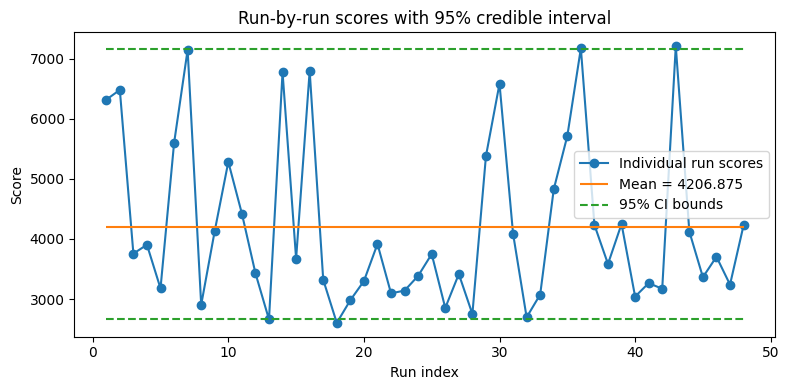

In [15]:
scores_vmog = []

for i in range(48):
    vmog_cluster_assignment_dict = np.load(f"vmog_runs/vmog_cluster_assignment_dict_tuned_{i+1}.npy", allow_pickle=True).item()
    shared_root_ids = list(set(root_id_type_dict.keys())
                       .intersection(set(vmog_cluster_assignment_dict.keys())))
    gt_assignments = np.array([cluster_string_to_cid[root_id_type_dict[root_id]] for root_id in shared_root_ids])
    vmog_assignments = np.array([vmog_cluster_assignment_dict[root_id] for root_id in shared_root_ids])
    score_vmog, _ = compare_two_assignments(gt_assignments, vmog_assignments)
    scores_vmog.append(score_vmog)
    
scores_vmog = np.array(scores_vmog)
mean_score_vmog = scores_vmog.mean()
lower_vmog, upper_vmog = np.percentile(scores_vmog, [2.5, 97.5])

print(f"Runs found : {len(scores_vmog)}")
print(f"Mean score : {mean_score_vmog:.4f}")
print(f"95% CI     : [{lower_vmog:.4f}, {upper_vmog:.4f}]")

runs_vmog = np.arange(1, len(scores_vmog) + 1)
plt.figure(figsize=(8,4))
plt.plot(runs_vmog, scores_vmog, 'o-', label="Individual run scores")
plt.hlines(mean_score_vmog, runs_vmog[0], runs_vmog[-1],
           colors='C1', linestyles='-', label=f"Mean = {mean_score_vmog:.3f}")
plt.hlines([lower_vmog, upper_vmog], runs_vmog[0], runs_vmog[-1],
           colors='C2', linestyles='--', label="95% CI bounds")
plt.xlabel("Run index")
plt.ylabel("Score")
plt.title("Run‑by‑run scores with 95% credible interval")
plt.legend()
plt.tight_layout()
plt.show()

Runs found : 48
Mean score : 2285.2292
95% CI     : [2231.8000, 2332.3750]


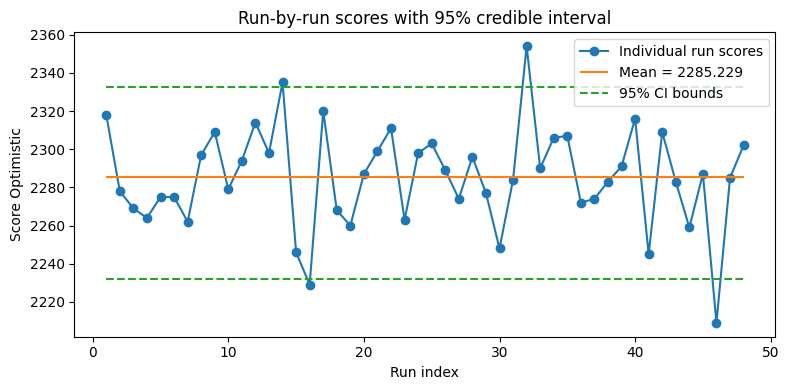

Runs found : 48
Mean score : 1282.0625
95% CI     : [1269.1750, 1298.0000]


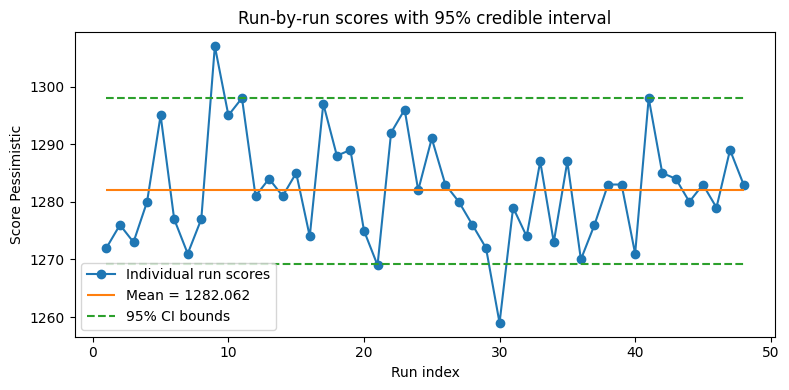

In [14]:
scores_optimistic = []
scores_pessimistic = []

for i in range(48):
    # create a random assignment by randomly permuting `target_assignment`
    random_assignment_optimistic = np.random.permutation(gt_assignments)
    random_assignment_pessimistic = np.random.randint(0, np.unique(gt_assignments).shape[0], gt_assignments.shape[0])
    
    gt_assignments = np.array([cluster_string_to_cid[root_id_type_dict[root_id]] for root_id in shared_root_ids])
    
    score_optimistic, _ = compare_two_assignments(gt_assignments, random_assignment_optimistic)
    scores_optimistic.append(score_optimistic)
    
    score_pessimistic, _ = compare_two_assignments(gt_assignments, random_assignment_pessimistic)
    scores_pessimistic.append(score_pessimistic)
    
scores_optimistic = np.array(scores_optimistic)
mean_score_optimistic = scores_optimistic.mean()
lower_optimistic, upper_optimistic = np.percentile(scores_optimistic, [2.5, 97.5])

print(f"Runs found : {len(scores_optimistic)}")
print(f"Mean score : {mean_score_optimistic:.4f}")
print(f"95% CI     : [{lower_optimistic:.4f}, {upper_optimistic:.4f}]")

runs_optimistic = np.arange(1, len(scores_optimistic) + 1)
plt.figure(figsize=(8,4))
plt.plot(runs_optimistic, scores_optimistic, 'o-', label="Individual run scores")
plt.hlines(mean_score_optimistic, runs_optimistic[0], runs_optimistic[-1],
           colors='C1', linestyles='-', label=f"Mean = {mean_score_optimistic:.3f}")
plt.hlines([lower_optimistic, upper_optimistic], runs_optimistic[0], runs_optimistic[-1],
           colors='C2', linestyles='--', label="95% CI bounds")
plt.xlabel("Run index")
plt.ylabel("Score Optimistic")
plt.title("Run‑by‑run scores with 95% credible interval")
plt.legend()
plt.tight_layout()
plt.show()

scores_pessimistic = np.array(scores_pessimistic)
mean_score_pessimistic = scores_pessimistic.mean()
lower_pessimistic, upper_pessimistic = np.percentile(scores_pessimistic, [2.5, 97.5])

print(f"Runs found : {len(scores_pessimistic)}")
print(f"Mean score : {mean_score_pessimistic:.4f}")
print(f"95% CI     : [{lower_pessimistic:.4f}, {upper_pessimistic:.4f}]")

runs_pessimistic = np.arange(1, len(scores_pessimistic) + 1)
plt.figure(figsize=(8,4))
plt.plot(runs_pessimistic, scores_pessimistic, 'o-', label="Individual run scores")
plt.hlines(mean_score_pessimistic, runs_pessimistic[0], runs_pessimistic[-1],
           colors='C1', linestyles='-', label=f"Mean = {mean_score_pessimistic:.3f}")
plt.hlines([lower_pessimistic, upper_pessimistic], runs_pessimistic[0], runs_pessimistic[-1],
           colors='C2', linestyles='--', label="95% CI bounds")
plt.xlabel("Run index")
plt.ylabel("Score Pessimistic")
plt.title("Run‑by‑run scores with 95% credible interval")
plt.legend()
plt.tight_layout()
plt.show()

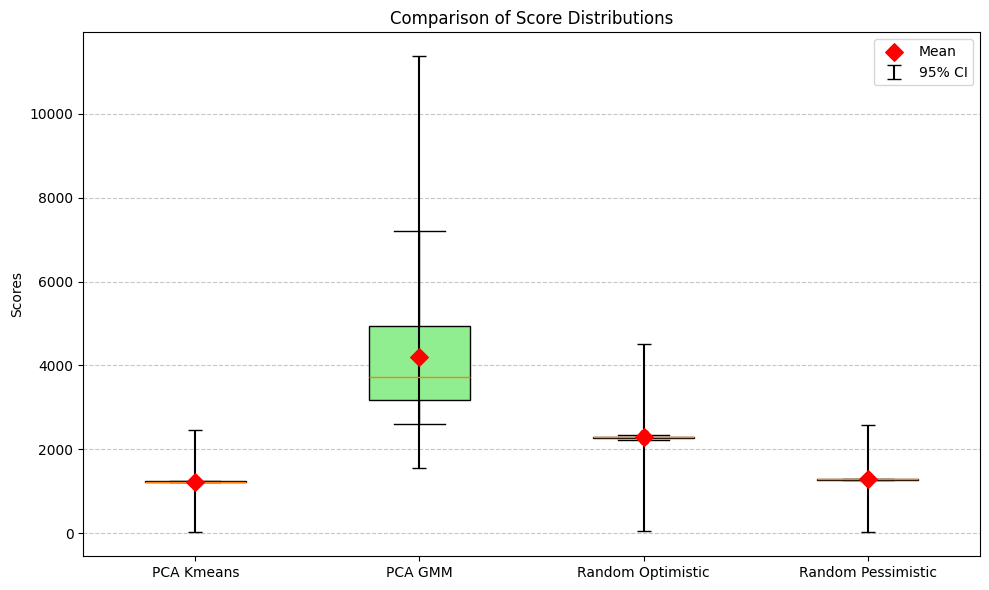

In [20]:
means = [np.mean(scores), np.mean(scores_vmog), np.mean(scores_optimistic), np.mean(scores_pessimistic)]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplots
data = [scores, scores_vmog, scores_optimistic, scores_pessimistic]
box = ax.boxplot(data, patch_artist=True, positions=[1, 2, 3, 4])

# Customize boxplot colors
colors = ['lightblue', 'lightgreen', 'lightsalmon', 'lavender']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add means as diamond markers
ax.scatter([1, 2, 3, 4], means, marker='D', color='red', s=80, zorder=3, label='Mean')

# Add credible intervals as error bars
ax.errorbar([1, 2, 3, 4], means, yerr=[
                [lower, lower_vmog, lower_optimistic, lower_pessimistic],
                [upper, upper_vmog, lower_optimistic, upper_pessimistic]
            ], fmt='none', color='black', capsize=5, label='95% CI')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Comparison of Score Distributions')
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['PCA Kmeans', 'PCA GMM', 'Random Optimistic', 'Random Pessimistic'])

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# should we be expecting higher variance from GMM?